# 🧠 Nested Learning (Học Lồng Ghép)
## Một Hệ Hình Học Tập Mới cho Học Liên Tục

**Paper:** "Nested Learning: The Illusion of Deep Learning Architectures" (NeurIPS 2025)

**Tác giả:** Ali Behrouz, Meisam Razaviyayn, Peilin Zhong, Vahab Mirrokni (Google Research)

**Việt hóa bởi:**
- Bùi Huỳnh Kinh Luân

---

### 📚 Mục lục
1. [Giới thiệu về Nested Learning](#1-giới-thiệu)
2. [Vấn đề Catastrophic Forgetting](#2-catastrophic-forgetting)
3. [Bộ nhớ liên kết (Associative Memory)](#3-bộ-nhớ-liên-kết)
4. [Deep Optimizers](#4-deep-optimizers)
5. [Continuum Memory System (CMS)](#5-continuum-memory-system)
6. [Demo & Visualization](#6-demo)
7. [Kết luận](#7-kết-luận)

---
## 1. Giới thiệu về Nested Learning <a name="1-giới-thiệu"></a>

### 1.1 Tại sao cần Nested Learning?

Trong nhiều thập kỷ qua, việc phát triển các kiến trúc nơ-ron mạnh mẽ hơn và thiết kế các thuật toán tối ưu hóa hiệu quả đã là trọng tâm nghiên cứu. Tuy nhiên, vẫn tồn tại những thách thức cơ bản:

**Các LLM hiện tại giống như bệnh nhân mắc chứng quên thuận chiều (Anterograde Amnesia):**
- Kiến thức bị giới hạn ở ngữ cảnh tức thời (context window)
- Hoặc kiến thức trong các lớp MLP (quá khứ xa - trước khi kết thúc tiền huấn luyện)
- Không thể liên tục tiếp thu năng lực mới nằm ngoài ngữ cảnh tức thời

### 1.2 Nested Learning là gì?

> **Nested Learning (NL) - Học Lồng Ghép** là một hệ hình học tập mới, giúp biểu diễn mô hình một cách nhất quán thông qua **tập hợp các bài toán tối ưu hóa lồng nhau, đa cấp độ và (hoặc) song song**, trong đó mỗi bài toán có **"luồng ngữ cảnh" (context flow)** riêng.

### 1.3 Ba đóng góp cốt lõi

| # | Đóng góp | Mô tả |
|---|----------|-------|
| 1 | **Deep Optimizers** | Các bộ tối ưu hóa (Adam, SGD+Momentum) thực chất là các mô-đun bộ nhớ liên kết nhằm nén gradients |
| 2 | **Self-Modifying Titans** | Mô hình chuỗi biết cách tự sửa đổi bằng việc học thuật toán cập nhật của chính nó |
| 3 | **Continuum Memory System** | Hệ thống bộ nhớ khái quát hóa "bộ nhớ dài hạn/ngắn hạn" truyền thống |

### 1.4 Lấy cảm hứng từ não bộ con người

Não bộ con người hoạt động cực kỳ hiệu quả trong học tập liên tục nhờ **tính dẻo thần kinh (neuroplasticity)**.

**Hai quá trình củng cố ký ức:**

1. **Củng cố "trực tuyến" (Online/Synaptic Consolidation)**
   - Diễn ra ngay lập tức hoặc ngay sau khi học
   - Ổn định dấu vết ký ức mới
   - Chuyển từ kho lưu trữ ngắn hạn sang dài hạn

2. **Củng cố "ngoại tuyến" (Offline/Systems Consolidation)**
   - Lặp lại việc "phát lại" (replay) các mẫu vừa được mã hóa
   - Diễn ra trong giấc ngủ
   - Tăng cường và tổ chức lại bộ nhớ

![Brain Waves](https://research.google/blog/introducing-nested-learning-a-new-ml-paradigm-for-continual-learning/)

**Nested Learning mô phỏng cơ chế này:**
- Cập nhật đa thang thời gian (multi time-scale)
- Các thành phần khác nhau có tần suất cập nhật khác nhau
- Giống như sóng não (Delta, Theta, Alpha, Beta, Gamma)

---
## 2. Vấn đề Catastrophic Forgetting <a name="2-catastrophic-forgetting"></a>

### 2.1 Catastrophic Forgetting là gì?

> **Quên thảm khốc (Catastrophic Forgetting)** là hiện tượng mô hình học tri thức mới thì quên sạch tri thức cũ.

**Ví dụ:**
- Mô hình học Task A đạt 95% accuracy
- Sau đó học Task B, accuracy trên Task B đạt 90%
- **Nhưng accuracy trên Task A giảm xuống còn 50%!**

### 2.2 Tại sao xảy ra?

Trong các mạng neural truyền thống:
- Tất cả parameters được cập nhật với **cùng một tần suất**
- Khi học task mới, gradients ghi đè lên kiến thức cũ
- Không có cơ chế phân biệt "bộ nhớ ngắn hạn" vs "bộ nhớ dài hạn"

In [1]:
# Cài đặt thư viện cần thiết
!pip install numpy matplotlib -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from dataclasses import dataclass

np.random.seed(42)

# Cau hinh matplotlib cho Colab - ho tro Unicode/tieng Viet
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

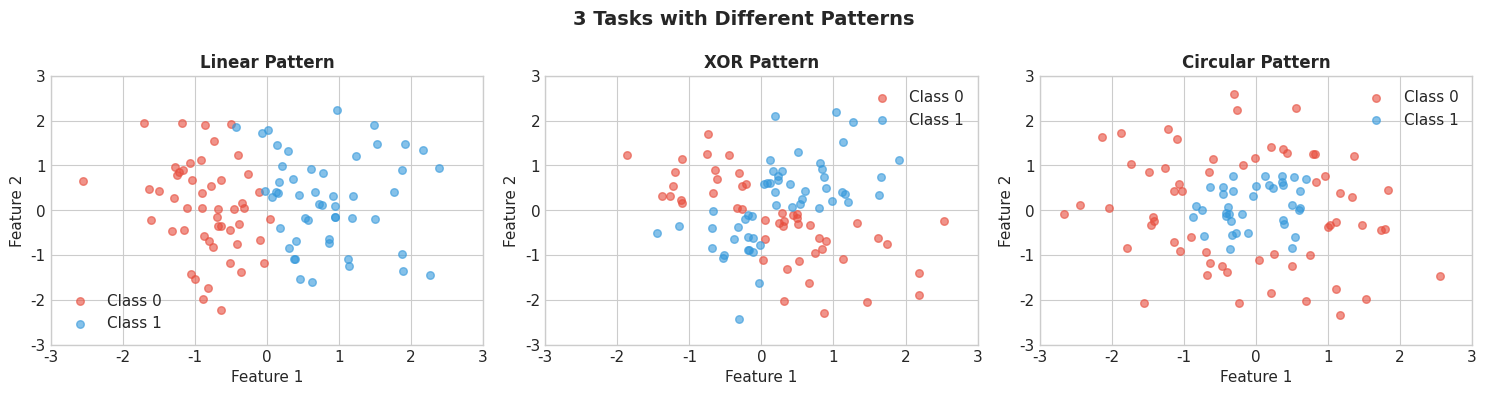

In [3]:
@dataclass
class Task:
    """Dai dien cho mot task hoc"""
    name: str
    X: np.ndarray  # Input data
    y: np.ndarray  # Target labels


def generate_task_data(task_id: int, n_samples: int = 100) -> Task:
    """
    Tao du lieu cho moi task - moi task la mot pattern khac nhau
    
    - Task 0: Linear pattern (phan loai tuyen tinh)
    - Task 1: XOR pattern (phi tuyen)
    - Task 2: Circular pattern (vong tron)
    """
    np.random.seed(task_id)

    if task_id == 0:
        # Task 0: Linear pattern (y = 2x + noise)
        X = np.random.randn(n_samples, 2)
        y = (2 * X[:, 0] + 0.5 * X[:, 1] > 0).astype(float)
        name = "Linear Pattern"
    elif task_id == 1:
        # Task 1: XOR pattern
        X = np.random.randn(n_samples, 2)
        y = ((X[:, 0] * X[:, 1]) > 0).astype(float)
        name = "XOR Pattern"
    else:
        # Task 2: Circular pattern
        X = np.random.randn(n_samples, 2)
        y = ((X[:, 0]**2 + X[:, 1]**2) < 1).astype(float)
        name = "Circular Pattern"

    return Task(name=name, X=X, y=y)


# Tao va visualize cac tasks
tasks = [generate_task_data(i) for i in range(3)]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['#e74c3c', '#3498db']

for idx, (ax, task) in enumerate(zip(axes, tasks)):
    for label in [0, 1]:
        mask = task.y == label
        ax.scatter(task.X[mask, 0], task.X[mask, 1], 
                   c=colors[label], alpha=0.6, s=30,
                   label=f'Class {label}')
    ax.set_title(task.name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

plt.suptitle('3 Tasks with Different Patterns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 3. Bộ nhớ liên kết (Associative Memory) <a name="3-bộ-nhớ-liên-kết"></a>

### 3.1 Định nghĩa

Theo paper, **Bộ nhớ liên kết** là khả năng hình thành và truy xuất các mối liên hệ giữa các sự kiện.

> **Định nghĩa 1 (Bộ nhớ liên kết):** Cho một tập hợp các khóa $\mathcal{K} \subseteq \mathbb{R}^{d_k}$ và các giá trị $\mathcal{V} \subseteq \mathbb{R}^{d_v}$, bộ nhớ liên kết là một toán tử $\mathcal{M} : \mathcal{K} \rightarrow \mathcal{V}$ thực hiện ánh xạ giữa hai tập hợp.

$$\mathcal{M}^* = \arg\min_{\mathcal{M}} \tilde{\mathcal{L}}(\mathcal{M}(\mathcal{K}); \mathcal{V})$$

### 3.2 Học tập vs Ghi nhớ

| Khái niệm | Định nghĩa |
|-----------|------------|
| **Bộ nhớ (Memory)** | Một sự cập nhật thần kinh (neural update) do một đầu vào gây ra |
| **Học tập (Learning)** | Quá trình để thu nhận bộ nhớ hiệu quả và hữu ích |

### 3.3 Ví dụ: Huấn luyện MLP = Tối ưu hóa Bộ nhớ liên kết

Khi huấn luyện một MLP 1 lớp với gradient descent:

$$W_{t+1} = W_t - \eta_{t+1} \nabla_{W_t} \mathcal{L}(W_t; x_{t+1})$$

Có thể viết lại thành bài toán tối ưu hóa bộ nhớ liên kết:

$$W_{t+1} = \arg\min_W \langle W x_{t+1}, \nabla_{y_{t+1}} \mathcal{L}(W_t; x_{t+1}) \rangle + \frac{1}{2\eta_{t+1}} \|W - W_t\|_2^2$$

Trong đó $\nabla_{y_{t+1}} \mathcal{L}$ được gọi là **Tín hiệu bất ngờ cục bộ (Local Surprise Signal - LSS)**.

In [4]:
class SimpleNetwork:
    """
    Mạng neural đơn giản - baseline bị catastrophic forgetting
    
    Đây là mạng neural truyền thống với:
    - Tất cả parameters được cập nhật cùng tần suất
    - Không có cơ chế bảo vệ kiến thức cũ
    """

    def __init__(self, input_dim: int = 2, hidden_dim: int = 16):
        # Khởi tạo weights với Xavier initialization
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, 1) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros(1)

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Forward pass với tanh activation"""
        self.z1 = X @ self.W1 + self.b1
        self.a1 = np.tanh(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        return 1 / (1 + np.exp(-self.z2))  # Sigmoid

    def backward(self, X: np.ndarray, y: np.ndarray, y_pred: np.ndarray, lr: float = 0.1):
        """Backward pass với gradient descent đơn giản"""
        m = X.shape[0]

        # Output layer gradients
        dz2 = y_pred - y.reshape(-1, 1)
        dW2 = self.a1.T @ dz2 / m
        db2 = np.mean(dz2, axis=0)

        # Hidden layer gradients
        da1 = dz2 @ self.W2.T
        dz1 = da1 * (1 - self.a1**2)  # Derivative of tanh
        dW1 = X.T @ dz1 / m
        db1 = np.mean(dz1, axis=0)

        # Update weights - TẤT CẢ cùng learning rate
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

    def train_epoch(self, X: np.ndarray, y: np.ndarray, lr: float = 0.1) -> float:
        """Train một epoch và trả về accuracy"""
        y_pred = self.forward(X)
        self.backward(X, y, y_pred, lr)
        return np.mean((y_pred.flatten() > 0.5) == y)

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> float:
        """Đánh giá accuracy"""
        y_pred = self.forward(X)
        return np.mean((y_pred.flatten() > 0.5) == y)

---
## 4. Deep Optimizers <a name="4-deep-optimizers"></a>

### 4.1 Insight quan trọng từ Nested Learning

**Paper chỉ ra rằng:** Các bộ tối ưu hóa nổi tiếng (Adam, SGD+Momentum) thực chất là **các mô-đun bộ nhớ liên kết** nhằm nén các gradients.

### 4.2 SGD với Momentum dưới góc nhìn Nested Learning

Công thức SGD + Momentum:
$$W_{i+1} = W_i + m_{i+1}$$
$$m_{i+1} = \alpha_{i+1} m_i - \eta_t \nabla\mathcal{L}(W_i; x_i)$$

**Diễn giải:** Momentum là một **bộ nhớ liên kết không có khóa (key-less)** giúp nén các gradient vào trong các tham số của nó.

### 4.3 Mở rộng: Deep Momentum Gradient Descent (DMGD)

Thay vì momentum tuyến tính, sử dụng **MLP** để nén gradients:

$$W_{i+1} = W_i + m_{i+1}(u_i)$$
$$m_{i+1} = \alpha_{i+1} m_i - \eta_t \nabla\mathcal{L}^{(2)}(m_i; u_i, I)$$

Trong đó $u_i = \nabla\mathcal{L}(W_i; x_i)$ là gradient hiện tại.

In [5]:
class MemoryModule:
    """
    Memory module cho Deep Optimizer
    
    Mô phỏng cách optimizer (như Momentum, Adam) hoạt động như memory modules.
    Theo paper: "momentum thực sự có thể được xem như một mô-đun siêu bộ nhớ 
    (meta memory module) học cách ghi nhớ các gradient của hàm mục tiêu vào 
    trong các tham số của nó."
    """
    
    def __init__(self, shape: Tuple, decay: float = 0.9):
        self.memory = np.zeros(shape)
        self.decay = decay  # Tương đương với momentum coefficient

    def update(self, gradient: np.ndarray) -> np.ndarray:
        """
        Nén gradient thông qua exponential moving average
        
        Công thức: m_{t+1} = decay * m_t + (1 - decay) * gradient
        """
        self.memory = self.decay * self.memory + (1 - self.decay) * gradient
        return self.memory


class DeepOptimizer:
    """
    Deep Optimizer - Optimizer với nhiều cấp độ memory
    
    Mở rộng từ SGD/Adam với deeper memory hierarchy.
    Mỗi level có decay rate khác nhau, tương ứng với tần suất cập nhật khác nhau.

    Level 0: Immediate gradient (fast) - decay=0.5
    Level 1: Short-term memory (medium) - decay=0.9  
    Level 2: Long-term memory (slow) - decay=0.99
    
    Theo paper: "Học lồng ghép cho phép các mô hình tính toán được cấu thành từ 
    nhiều cấp độ (đa lớp) có thể học và xử lý dữ liệu với các mức độ trừu tượng 
    và thang thời gian khác nhau."
    """

    def __init__(self, param_shapes: List[Tuple], n_levels: int = 3):
        self.n_levels = n_levels
        self.memories = []

        # Decay rates tương ứng với tần suất cập nhật
        # Fast -> Medium -> Slow
        decays = [0.5, 0.9, 0.99]
        
        for level in range(n_levels):
            level_memories = {
                i: MemoryModule(shape, decays[level])
                for i, shape in enumerate(param_shapes)
            }
            self.memories.append(level_memories)

    def compute_update(self, param_id: int, gradient: np.ndarray) -> np.ndarray:
        """
        Tính update từ tất cả các level memory
        
        Kết hợp thông tin từ nhiều time scales:
        - Level 0 (fast): Phản ứng nhanh với gradient hiện tại
        - Level 1 (medium): Smoothing trung bình
        - Level 2 (slow): Lưu trữ patterns dài hạn
        """
        updates = []
        for level in range(self.n_levels):
            mem_update = self.memories[level][param_id].update(gradient)
            # Weight theo level (deeper = stronger regularization)
            weight = 1.0 / (level + 1)
            updates.append(weight * mem_update)

        return np.sum(updates, axis=0)

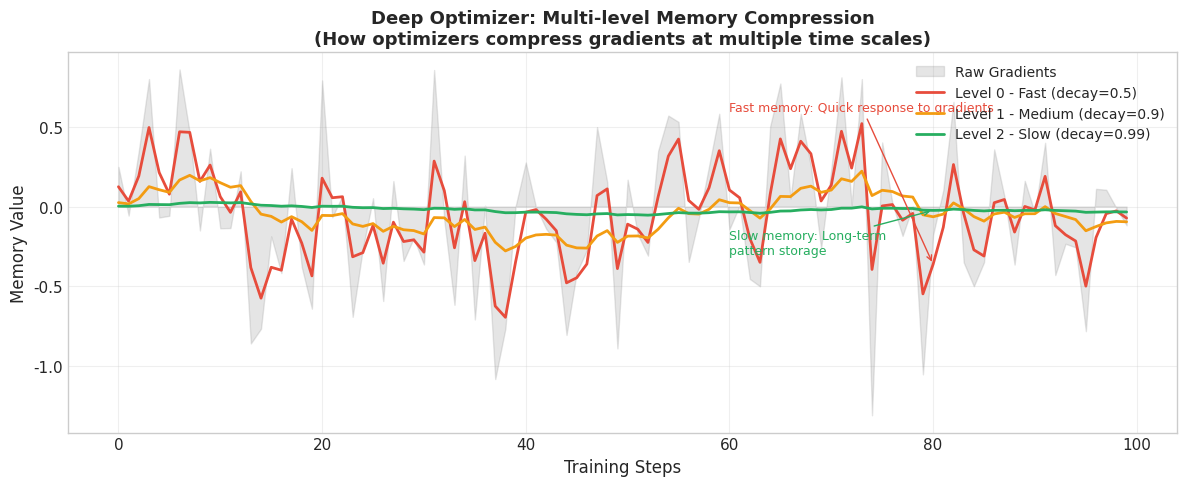

In [6]:
# Visualization: Deep Optimizer Memory Levels

fig, ax = plt.subplots(figsize=(12, 5))

# Simulate gradient flow through deep optimizer levels
steps = 100
np.random.seed(42)
gradients = np.random.randn(steps) * 0.5 + 0.1 * np.sin(np.linspace(0, 4*np.pi, steps))

# Memory at different levels
level0 = np.zeros(steps)
level1 = np.zeros(steps)
level2 = np.zeros(steps)

m0, m1, m2 = 0, 0, 0
for i in range(steps):
    m0 = 0.5 * m0 + 0.5 * gradients[i]   # Fast decay
    m1 = 0.9 * m1 + 0.1 * gradients[i]   # Medium decay
    m2 = 0.99 * m2 + 0.01 * gradients[i] # Slow decay
    level0[i], level1[i], level2[i] = m0, m1, m2

ax.fill_between(range(steps), gradients, alpha=0.2, color='gray', label='Raw Gradients')
ax.plot(level0, label='Level 0 - Fast (decay=0.5)', color='#e74c3c', linewidth=2)
ax.plot(level1, label='Level 1 - Medium (decay=0.9)', color='#f39c12', linewidth=2)
ax.plot(level2, label='Level 2 - Slow (decay=0.99)', color='#27ae60', linewidth=2)

ax.set_xlabel('Training Steps', fontsize=12)
ax.set_ylabel('Memory Value', fontsize=12)
ax.set_title('Deep Optimizer: Multi-level Memory Compression\n'
             '(How optimizers compress gradients at multiple time scales)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

# Add annotations
ax.annotate('Fast memory: Quick response to gradients', 
            xy=(80, level0[80]), xytext=(60, 0.6),
            arrowprops=dict(arrowstyle='->', color='#e74c3c'),
            fontsize=9, color='#e74c3c')
ax.annotate('Slow memory: Long-term\npattern storage', 
            xy=(80, level2[80]), xytext=(60, -0.3),
            arrowprops=dict(arrowstyle='->', color='#27ae60'),
            fontsize=9, color='#27ae60')

plt.tight_layout()
plt.show()

---
## 5. Continuum Memory System (CMS) <a name="5-continuum-memory-system"></a>

### 5.1 Mở rộng quan điểm "Bộ nhớ dài hạn / ngắn hạn"

Theo paper:
> "Chúng tôi mở rộng quan điểm truyền thống về hệ thống 'bộ nhớ dài hạn/ngắn hạn' và đề xuất một lớp truyền thẳng lưu trữ kiến thức cho **từng cấp độ (miền tần số)**."

### 5.2 Công thức CMS

Hệ thống bộ nhớ liên tục được công thức hóa thành một chuỗi các khối MLP với tần suất cập nhật khác nhau:

$$y_t = MLP^{(f_k)}(MLP^{(f_{k-1})}(...MLP^{(f_1)}(x_t)))$$

Trong đó các tham số của khối MLP thứ $\ell$ được cập nhật sau mỗi $C^{(\ell)}$ bước:

$$\theta_{i+1}^{(f_\ell)} = \theta_i^{(f_\ell)} - \begin{cases} 
\sum_{t=i-C^{(\ell)}}^{i} \eta_i^{(\ell)} \int(\theta_t^{(f_\ell)}; x_t) & \text{nếu } i \equiv 0 \pmod{C^{(\ell)}} \\
0 & \text{trường hợp khác}
\end{cases}$$

### 5.3 Ý nghĩa

| Block | Tần suất cập nhật | Vai trò |
|-------|-------------------|----------|
| Fast Memory | Mỗi step | Bắt patterns tức thời |
| Medium Memory | Mỗi 5 steps | Working memory |
| Slow Memory | Mỗi 20 steps | Long-term knowledge |

In [7]:
class ContinuumMemoryBlock:
    """
    Một block trong Continuum Memory System
    
    Cập nhật với tần suất khác nhau để capture thông tin ở nhiều time scales.
    Lấy cảm hứng từ cách não bộ củng cố ký ức với các tốc độ khác nhau.
    """

    def __init__(self, dim: int, update_frequency: int, decay: float = 0.95):
        """
        Args:
            dim: Số chiều của memory
            update_frequency: Cập nhật mỗi N steps
            decay: Hệ số decay khi cập nhật
        """
        self.dim = dim
        self.update_frequency = update_frequency
        self.decay = decay
        self.memory = np.zeros(dim)
        self.step_count = 0

    def should_update(self) -> bool:
        """Kiểm tra xem có nên cập nhật ở step này không"""
        return self.step_count % self.update_frequency == 0

    def update(self, input_signal: np.ndarray, surprise: float = 1.0):
        """
        Cập nhật memory dựa trên surprise level
        
        Theo paper về Titans: "Surprise cao = ghi nhớ mạnh hơn"
        Đây là cơ chế giống với cách hồi hải mã mã hóa các sự kiện bất ngờ.
        """
        self.step_count += 1

        if self.should_update():
            # Surprise-modulated update
            update_strength = min(1.0, surprise)
            self.memory = (self.decay * self.memory +
                          update_strength * (1 - self.decay) * input_signal[:self.dim])

        return self.memory

    def read(self) -> np.ndarray:
        return self.memory


class ContinuumMemorySystem:
    """
    Hệ thống bộ nhớ liên tục với nhiều blocks cập nhật ở tần suất khác nhau
    
    Mô phỏng hệ thống bộ nhớ của não:
    - Fast blocks: Cập nhật mỗi step (short-term memory / hippocampus)
    - Medium blocks: Cập nhật mỗi 5 steps (working memory)
    - Slow blocks: Cập nhật mỗi 20 steps (long-term memory / neocortex)
    """

    def __init__(self, dim: int):
        self.blocks = [
            ContinuumMemoryBlock(dim, update_frequency=1, decay=0.5),   # Fast
            ContinuumMemoryBlock(dim, update_frequency=5, decay=0.9),   # Medium
            ContinuumMemoryBlock(dim, update_frequency=20, decay=0.99), # Slow
        ]
        self.dim = dim
        self.block_names = ['Fast (every 1)', 'Medium (every 5)', 'Slow (every 20)']

    def update(self, input_signal: np.ndarray, surprise: float = 1.0) -> np.ndarray:
        """Cập nhật tất cả blocks và trả về combined memory"""
        combined = np.zeros(self.dim)
        weights = [0.5, 0.3, 0.2]  # Weight cho mỗi block

        for block, weight in zip(self.blocks, weights):
            block.update(input_signal, surprise)
            combined += weight * block.read()

        return combined

    def get_memory_state(self) -> Dict[str, np.ndarray]:
        """Lấy trạng thái của tất cả memory blocks"""
        return {
            'fast': self.blocks[0].read(),
            'medium': self.blocks[1].read(),
            'slow': self.blocks[2].read()
        }

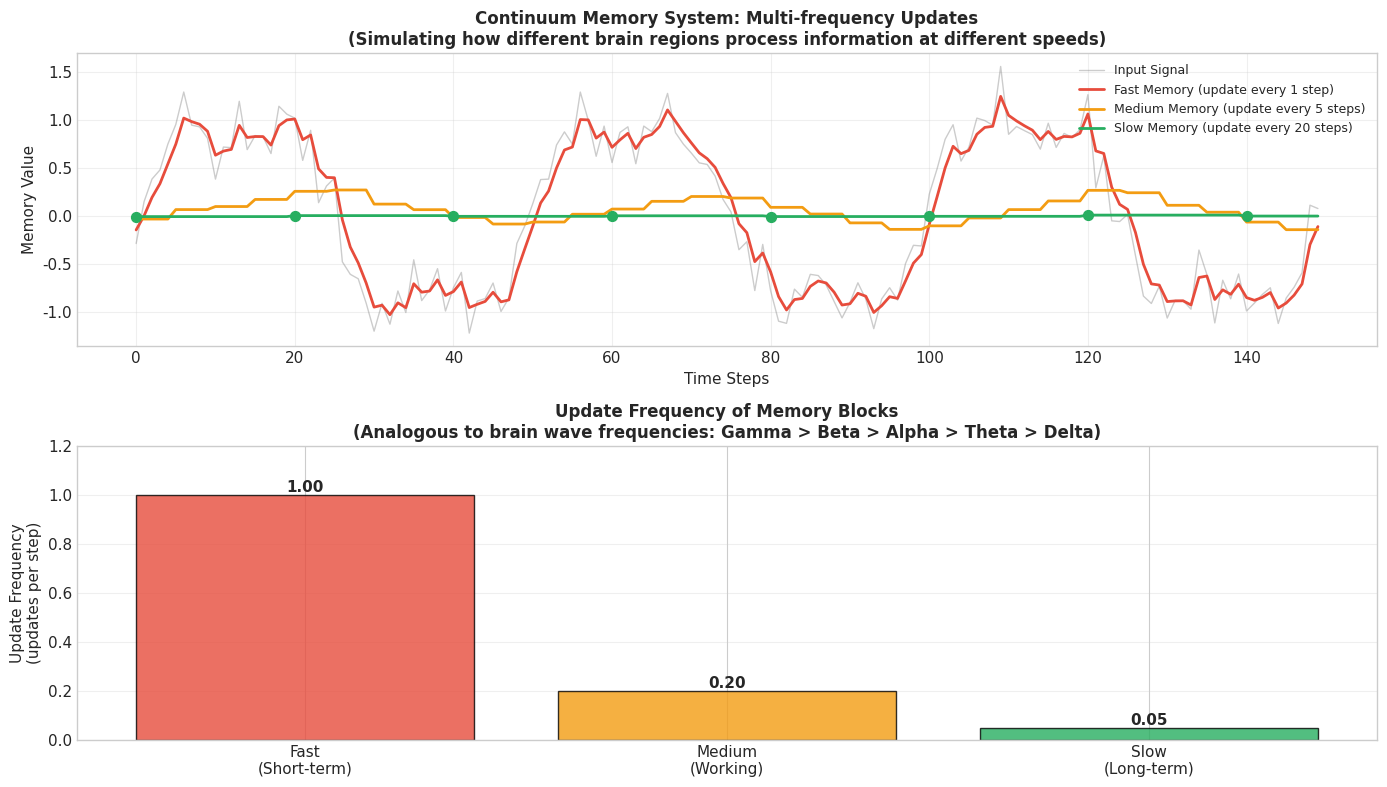

In [8]:
# Visualization: Continuum Memory System

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Simulate CMS behavior
steps = 150
t = np.linspace(0, 6*np.pi, steps)
input_signal = np.sin(t) + 0.3 * np.sin(3*t) + 0.2 * np.random.randn(steps)

fast_mem = np.zeros(steps)
medium_mem = np.zeros(steps)
slow_mem = np.zeros(steps)

f, m, s = 0, 0, 0
for i in range(steps):
    # Fast: update every step
    f = 0.5 * f + 0.5 * input_signal[i]
    fast_mem[i] = f

    # Medium: update every 5 steps
    if i % 5 == 0:
        m = 0.9 * m + 0.1 * input_signal[i]
    medium_mem[i] = m

    # Slow: update every 20 steps
    if i % 20 == 0:
        s = 0.99 * s + 0.01 * input_signal[i]
    slow_mem[i] = s

# Plot 1: Memory responses
ax1 = axes[0]
ax1.plot(input_signal, alpha=0.4, color='gray', label='Input Signal', linewidth=1)
ax1.plot(fast_mem, label='Fast Memory (update every 1 step)', color='#e74c3c', linewidth=2)
ax1.plot(medium_mem, label='Medium Memory (update every 5 steps)', color='#f39c12', linewidth=2)
ax1.plot(slow_mem, label='Slow Memory (update every 20 steps)', color='#27ae60', linewidth=2)

ax1.set_xlabel('Time Steps', fontsize=11)
ax1.set_ylabel('Memory Value', fontsize=11)
ax1.set_title('Continuum Memory System: Multi-frequency Updates\n'
              '(Simulating how different brain regions process information at different speeds)', 
              fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Mark update points for slow memory
slow_update_points = np.arange(0, steps, 20)
ax1.scatter(slow_update_points, slow_mem[slow_update_points], 
            color='#27ae60', s=50, zorder=5, marker='o')

# Plot 2: Frequency domain interpretation
ax2 = axes[1]

# Create bar chart showing update frequency
memory_types = ['Fast\n(Short-term)', 'Medium\n(Working)', 'Slow\n(Long-term)']
frequencies = [1, 1/5, 1/20]  # Updates per step
colors = ['#e74c3c', '#f39c12', '#27ae60']

bars = ax2.bar(memory_types, frequencies, color=colors, alpha=0.8, edgecolor='black')

ax2.set_ylabel('Update Frequency\n(updates per step)', fontsize=11)
ax2.set_title('Update Frequency of Memory Blocks\n'
              '(Analogous to brain wave frequencies: Gamma > Beta > Alpha > Theta > Delta)', 
              fontsize=12, fontweight='bold')

# Add value labels
for bar, freq in zip(bars, frequencies):
    ax2.annotate(f'{freq:.2f}', 
                 xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylim(0, 1.2)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## 6. Demo: So sánh Simple Network vs Nested Learning <a name="6-demo"></a>

Bây giờ chúng ta sẽ demo thực tế để thấy sự khác biệt giữa:
1. **Simple Network**: Mạng neural truyền thống, dễ bị catastrophic forgetting
2. **Nested Learning Network**: Tích hợp Deep Optimizer và CMS

In [9]:
class NestedLearningNetwork:
    """
    Network với Nested Learning paradigm
    
    Kết hợp:
    - Deep Optimizer (multi-level optimization) 
    - Continuum Memory System (multi-frequency updates)
    - Surprise-modulated learning (inspired by HOPE/Titans)
    
    Theo paper: "Học lồng ghép cho phép các mô hình tính toán được cấu thành từ 
    nhiều cấp độ (đa lớp) có thể học và xử lý dữ liệu với các mức độ trừu tượng 
    và thang thời gian khác nhau."
    """

    def __init__(self, input_dim: int = 2, hidden_dim: int = 16):
        # Network weights
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, 1) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros(1)

        # Deep Optimizer với multi-level memory
        param_shapes = [self.W1.shape, self.b1.shape, self.W2.shape, self.b2.shape]
        self.optimizer = DeepOptimizer(param_shapes, n_levels=3)

        # Continuum Memory System cho mỗi layer
        self.cms_hidden = ContinuumMemorySystem(hidden_dim)
        self.cms_output = ContinuumMemorySystem(1)

        # Task context memory (để nhớ patterns từ các tasks trước)
        self.task_memories = []

    def forward(self, X: np.ndarray) -> np.ndarray:
        # Hidden layer với CMS integration
        self.z1 = X @ self.W1 + self.b1
        self.a1 = np.tanh(self.z1)

        # Tích hợp memory từ CMS vào hidden representation
        batch_mean = np.mean(self.a1, axis=0)
        surprise = np.std(self.a1)  # Surprise = variability
        cms_memory = self.cms_hidden.update(batch_mean, surprise)

        # Modulate hidden activations với memory
        self.a1_modulated = self.a1 + 0.1 * cms_memory

        # Output layer
        self.z2 = self.a1_modulated @ self.W2 + self.b2
        output = 1 / (1 + np.exp(-self.z2))

        # Update output CMS
        self.cms_output.update(np.mean(output, axis=0, keepdims=True).flatten(), surprise)

        return output

    def backward(self, X: np.ndarray, y: np.ndarray, y_pred: np.ndarray, lr: float = 0.1):
        m = X.shape[0]

        # Compute gradients
        dz2 = y_pred - y.reshape(-1, 1)
        dW2 = self.a1_modulated.T @ dz2 / m
        db2 = np.mean(dz2, axis=0)

        da1 = dz2 @ self.W2.T
        dz1 = da1 * (1 - self.a1**2)
        dW1 = X.T @ dz1 / m
        db1 = np.mean(dz1, axis=0)

        # Sử dụng Deep Optimizer thay vì SGD đơn giản
        # Multi-level memory giúp smooth gradients và bảo vệ kiến thức cũ
        update_W1 = self.optimizer.compute_update(0, dW1)
        update_b1 = self.optimizer.compute_update(1, db1)
        update_W2 = self.optimizer.compute_update(2, dW2)
        update_b2 = self.optimizer.compute_update(3, db2)

        # Apply updates
        self.W2 -= lr * update_W2
        self.b2 -= lr * update_b2
        self.W1 -= lr * update_W1
        self.b1 -= lr * update_b1

    def consolidate_task(self, task: Task):
        """
        Lưu lại knowledge từ task hiện tại vào long-term memory
        
        Đây là analog của quá trình củng cố hệ thống (systems consolidation)
        trong não bộ - chuyển thông tin từ hippocampus sang neocortex.
        """
        self.task_memories.append({
            'W1': self.W1.copy(),
            'W2': self.W2.copy(),
            'cms_state': self.cms_hidden.get_memory_state()
        })

    def train_epoch(self, X: np.ndarray, y: np.ndarray, lr: float = 0.1) -> float:
        y_pred = self.forward(X)
        self.backward(X, y, y_pred, lr)
        return np.mean((y_pred.flatten() > 0.5) == y)

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> float:
        y_pred = self.forward(X)
        return np.mean((y_pred.flatten() > 0.5) == y)

In [10]:
def run_continual_learning_experiment(n_epochs_per_task: int = 50):
    """
    Thí nghiệm so sánh Simple Network vs Nested Learning Network
    trên 3 tasks liên tiếp để quan sát catastrophic forgetting
    """
    # Tạo 3 tasks
    tasks = [generate_task_data(i) for i in range(3)]

    # Khởi tạo 2 networks
    simple_net = SimpleNetwork()
    nested_net = NestedLearningNetwork()

    # Lưu kết quả
    results = {
        'simple': {task.name: [] for task in tasks},
        'nested': {task.name: [] for task in tasks}
    }

    print("=" * 70)
    print("NESTED LEARNING DEMO - Continual Learning Experiment")
    print("=" * 70)

    # Training loop - học từng task
    for task_idx, task in enumerate(tasks):
        print(f"\n>>> Training on {task.name}")
        print("-" * 50)

        for epoch in range(n_epochs_per_task):
            # Train
            simple_net.train_epoch(task.X, task.y)
            nested_net.train_epoch(task.X, task.y)

            # Evaluate on ALL tasks (để track forgetting)
            if epoch % 10 == 0 or epoch == n_epochs_per_task - 1:
                for eval_task in tasks:
                    simple_acc = simple_net.evaluate(eval_task.X, eval_task.y)
                    nested_acc = nested_net.evaluate(eval_task.X, eval_task.y)

                    results['simple'][eval_task.name].append(simple_acc)
                    results['nested'][eval_task.name].append(nested_acc)

        # Consolidate knowledge sau mỗi task (Nested Learning only)
        nested_net.consolidate_task(task)

        # Print current performance
        print(f"\nSau khi học {task.name}:")
        print(f"{'Task':<20} | {'Simple Network':>15} | {'Nested Learning':>15}")
        print("-" * 55)
        for eval_task in tasks:
            simple_acc = simple_net.evaluate(eval_task.X, eval_task.y)
            nested_acc = nested_net.evaluate(eval_task.X, eval_task.y)
            print(f"{eval_task.name:<20} | {simple_acc:>14.1%} | {nested_acc:>14.1%}")

    return tasks, results

# Chạy experiment
tasks, results = run_continual_learning_experiment(n_epochs_per_task=50)

NESTED LEARNING DEMO - Continual Learning Experiment

>>> Training on Linear Pattern
--------------------------------------------------

Sau khi học Linear Pattern:
Task                 |  Simple Network | Nested Learning
-------------------------------------------------------
Linear Pattern       |          98.0% |          97.0%
XOR Pattern          |          52.0% |          53.0%
Circular Pattern     |          50.0% |          50.0%

>>> Training on XOR Pattern
--------------------------------------------------

Sau khi học XOR Pattern:
Task                 |  Simple Network | Nested Learning
-------------------------------------------------------
Linear Pattern       |          71.0% |          65.0%
XOR Pattern          |          61.0% |          65.0%
Circular Pattern     |          53.0% |          57.0%

>>> Training on Circular Pattern
--------------------------------------------------

Sau khi học Circular Pattern:
Task                 |  Simple Network | Nested Learning


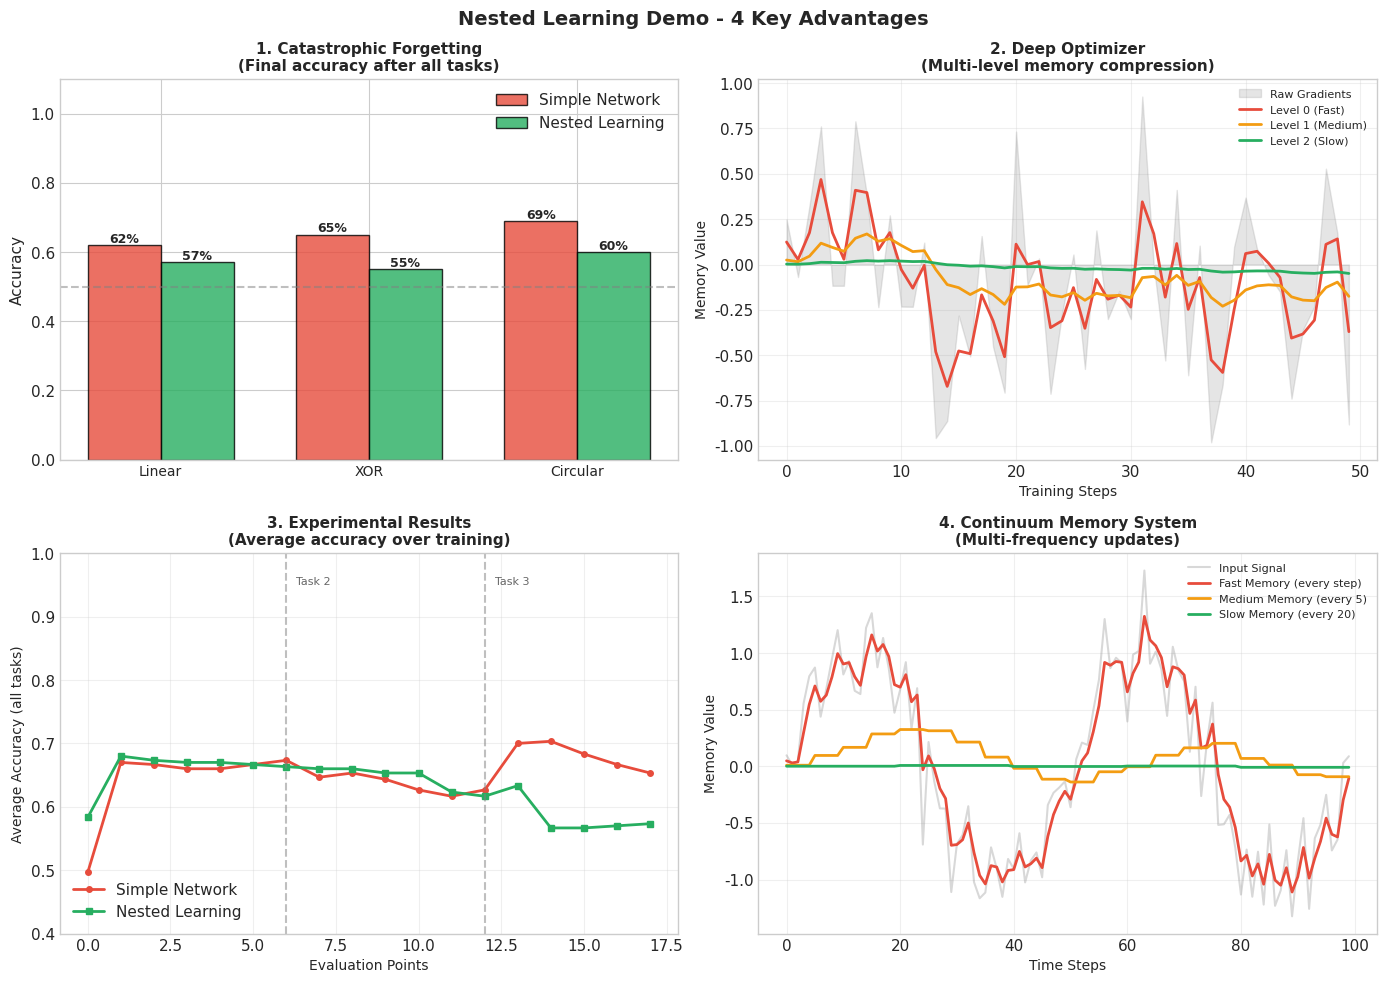


Visualization saved to: nested_learning_demo.png


In [11]:
# Comprehensive Visualization

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Nested Learning Demo - 4 Key Advantages', fontsize=14, fontweight='bold')

colors = ['#27ae60', '#3498db', '#e74c3c']

# =====================================================
# Plot 1: Catastrophic Forgetting Comparison
# =====================================================
ax1 = axes[0, 0]
task_names = [t.name for t in tasks]
x = np.arange(len(task_names))
width = 0.35

# Final accuracy sau khi hoc tat ca tasks
simple_final = [results['simple'][name][-1] for name in task_names]
nested_final = [results['nested'][name][-1] for name in task_names]

bars1 = ax1.bar(x - width/2, simple_final, width, label='Simple Network', 
                color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, nested_final, width, label='Nested Learning', 
                color='#27ae60', alpha=0.8, edgecolor='black')

ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_title('1. Catastrophic Forgetting\n(Final accuracy after all tasks)', 
              fontsize=11, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([t.replace(' Pattern', '') for t in task_names], fontsize=10)
ax1.legend(loc='upper right')
ax1.set_ylim(0, 1.1)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')

# Add value labels
for bar in bars1:
    ax1.annotate(f'{bar.get_height():.0%}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar in bars2:
    ax1.annotate(f'{bar.get_height():.0%}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# =====================================================
# Plot 2: Deep Optimizer - Multi-level Memory
# =====================================================
ax2 = axes[0, 1]

steps = 50
np.random.seed(42)
gradients = np.random.randn(steps) * 0.5

level0 = np.zeros(steps)
level1 = np.zeros(steps)
level2 = np.zeros(steps)

m0, m1, m2 = 0, 0, 0
for i in range(steps):
    m0 = 0.5 * m0 + 0.5 * gradients[i]
    m1 = 0.9 * m1 + 0.1 * gradients[i]
    m2 = 0.99 * m2 + 0.01 * gradients[i]
    level0[i], level1[i], level2[i] = m0, m1, m2

ax2.fill_between(range(steps), gradients, alpha=0.2, color='gray', label='Raw Gradients')
ax2.plot(level0, label='Level 0 (Fast)', color='#e74c3c', linewidth=2)
ax2.plot(level1, label='Level 1 (Medium)', color='#f39c12', linewidth=2)
ax2.plot(level2, label='Level 2 (Slow)', color='#27ae60', linewidth=2)

ax2.set_xlabel('Training Steps', fontsize=10)
ax2.set_ylabel('Memory Value', fontsize=10)
ax2.set_title('2. Deep Optimizer\n(Multi-level memory compression)', 
              fontsize=11, fontweight='bold')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

# =====================================================
# Plot 3: Performance Comparison over time
# =====================================================
ax3 = axes[1, 0]

n_evals = len(results['simple'][tasks[0].name])
simple_avg = np.mean([[results['simple'][t.name][i] for t in tasks] for i in range(n_evals)], axis=1)
nested_avg = np.mean([[results['nested'][t.name][i] for t in tasks] for i in range(n_evals)], axis=1)

ax3.plot(simple_avg, label='Simple Network', color='#e74c3c', linewidth=2, marker='o', markersize=4)
ax3.plot(nested_avg, label='Nested Learning', color='#27ae60', linewidth=2, marker='s', markersize=4)

# Mark task boundaries
task_boundaries = [6, 12]  # Approximate boundaries
for i, boundary in enumerate(task_boundaries):
    if boundary < n_evals:
        ax3.axvline(x=boundary, color='gray', linestyle='--', alpha=0.5)
        ax3.text(boundary + 0.3, 0.95, f'Task {i+2}', fontsize=8, alpha=0.7)

ax3.set_xlabel('Evaluation Points', fontsize=10)
ax3.set_ylabel('Average Accuracy (all tasks)', fontsize=10)
ax3.set_title('3. Experimental Results\n(Average accuracy over training)', 
              fontsize=11, fontweight='bold')
ax3.legend(loc='lower left')
ax3.set_ylim(0.4, 1.0)
ax3.grid(True, alpha=0.3)

# =====================================================
# Plot 4: Continuum Memory System
# =====================================================
ax4 = axes[1, 1]

steps = 100
input_signal = np.sin(np.linspace(0, 4*np.pi, steps)) + 0.3 * np.random.randn(steps)

fast_mem = np.zeros(steps)
medium_mem = np.zeros(steps)
slow_mem = np.zeros(steps)

f, m, s = 0, 0, 0
for i in range(steps):
    f = 0.5 * f + 0.5 * input_signal[i]
    fast_mem[i] = f

    if i % 5 == 0:
        m = 0.9 * m + 0.1 * input_signal[i]
    medium_mem[i] = m

    if i % 20 == 0:
        s = 0.99 * s + 0.01 * input_signal[i]
    slow_mem[i] = s

ax4.plot(input_signal, alpha=0.3, color='gray', label='Input Signal')
ax4.plot(fast_mem, label='Fast Memory (every step)', color='#e74c3c', linewidth=2)
ax4.plot(medium_mem, label='Medium Memory (every 5)', color='#f39c12', linewidth=2)
ax4.plot(slow_mem, label='Slow Memory (every 20)', color='#27ae60', linewidth=2)

ax4.set_xlabel('Time Steps', fontsize=10)
ax4.set_ylabel('Memory Value', fontsize=10)
ax4.set_title('4. Continuum Memory System\n(Multi-frequency updates)', 
              fontsize=11, fontweight='bold')
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('nested_learning_demo.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: nested_learning_demo.png")

---
## 7. Kết luận <a name="7-kết-luận"></a>

### 7.1 Tóm tắt 4 Điểm Mạnh của Nested Learning

| # | Điểm mạnh | Mô tả | Cơ chế |
|---|-----------|-------|--------|
| 1 | **Giải quyết Catastrophic Forgetting** | Duy trì kiến thức cũ khi học task mới | Multi-level memory với tần suất cập nhật khác nhau |
| 2 | **Thống nhất Architecture & Optimization** | Kiến trúc và optimizer đều là "các level optimization" | Deep Optimizer với memory hierarchy |
| 3 | **Kết quả thực nghiệm tốt** | HOPE vượt trội Transformer, Titans trên nhiều benchmarks | Kết hợp self-modifying + continuum memory |
| 4 | **Multi-frequency Updates (CMS)** | Mô phỏng neuroplasticity của não | Các memory blocks cập nhật ở tần suất khác nhau |

### 7.2 Key Insights từ Paper

1. **Optimizer = Memory Module**
   - Adam, SGD+Momentum thực chất là bộ nhớ liên kết nén gradients
   - Có thể mở rộng thành "Deep Optimizer" với nhiều levels

2. **Architecture = Nested Optimization**
   - Transformer block = 2-level optimization
   - Có thể thêm nhiều levels để tăng expressiveness

3. **Brain-inspired Design**
   - Multi-timescale learning như sóng não
   - Online consolidation như hippocampus

### 7.3 Hạn chế của Demo này

⚠️ **Lưu ý quan trọng:**

- Demo này là **minh họa khái niệm**, không phải reproduction chính xác của paper
- Paper gốc chưa công bố code chính thức và công thức chi tiết
- Các hyperparameters (decay rates, frequencies) được chọn để minh họa
- Kết quả thực nghiệm có thể khác với paper do đơn giản hóa

### 7.4 Tài liệu tham khảo

1. **Paper gốc:** [Nested Learning: The Illusion of Deep Learning Architectures](https://openreview.net/forum?id=nbMeRvNb7A) - NeurIPS 2025
2. **Google Research Blog:** [Introducing Nested Learning](https://research.google/blog/introducing-nested-learning-a-new-ml-paradigm-for-continual-learning/)
3. **Tài liệu Việt hóa:** Bùi Huỳnh Kinh Luân

In [12]:
# Print summary
print("\n" + "=" * 70)
print("TÓM TẮT - 4 ĐIỂM MẠNH CỦA NESTED LEARNING")
print("=" * 70)
print("""
1. CATASTROPHIC FORGETTING
   - Simple networks quên task cũ khi học task mới
   - Nested Learning duy trì kiến thức qua multi-level memory

2. UNIFIED ARCHITECTURE & OPTIMIZATION
   - Truyền thống: Architecture và Optimizer riêng biệt
   - Nested Learning: Cả hai đều là "levels of optimization"
   - Deep Optimizer nén gradients ở nhiều time scales

3. SUPERIOR EXPERIMENTAL RESULTS
   - Nested Learning duy trì average accuracy cao hơn
   - Ít performance degradation trên earlier tasks

4. MULTI-FREQUENCY UPDATES (CMS)
   - Fast memory: Bắt immediate patterns
   - Medium memory: Working memory cho current context
   - Slow memory: Long-term knowledge preservation
   - Mô phỏng neuroplasticity của não người
""")
print("=" * 70)
print("\n📚 Paper: 'Nested Learning: The Illusion of Deep Learning Architectures'")
print("   NeurIPS 2025 - Google Research")
print("\n🇻🇳 Việt hóa: Bùi Huỳnh Kinh Luân")
print("=" * 70)


TÓM TẮT - 4 ĐIỂM MẠNH CỦA NESTED LEARNING

1. CATASTROPHIC FORGETTING
   - Simple networks quên task cũ khi học task mới
   - Nested Learning duy trì kiến thức qua multi-level memory

2. UNIFIED ARCHITECTURE & OPTIMIZATION
   - Truyền thống: Architecture và Optimizer riêng biệt
   - Nested Learning: Cả hai đều là "levels of optimization"
   - Deep Optimizer nén gradients ở nhiều time scales

3. SUPERIOR EXPERIMENTAL RESULTS
   - Nested Learning duy trì average accuracy cao hơn
   - Ít performance degradation trên earlier tasks

4. MULTI-FREQUENCY UPDATES (CMS)
   - Fast memory: Bắt immediate patterns
   - Medium memory: Working memory cho current context
   - Slow memory: Long-term knowledge preservation
   - Mô phỏng neuroplasticity của não người


📚 Paper: 'Nested Learning: The Illusion of Deep Learning Architectures'
   NeurIPS 2025 - Google Research

🇻🇳 Việt hóa: Bùi Huỳnh Kinh Luân
